### Analysis of Federal Trade Commission complaints related to 'immigration services' 

This notebook runs two analyses of Federal Trade Commission (FTC) data

In [1]:
import pandas as pd
import spacy
import xlrd
%matplotlib inline

In this section we open up all Excel sheets and isolate the data to the relevant columns

In [2]:
ftc_complaints_2006_2015 = pd.read_excel(
    '../data/consumer_compls_redacted_2006_2015.xlsx',
    sheet_name = 'CIS Complaint'
)

ftc_complaints_2015_2017 = pd.read_excel('../data/consumer_compls_redacted_2015_2017.xls')

ftc_complaints_2018 = pd.read_excel('../data/consumer_compls_redacted_2018.xlsx')

In [3]:
print(len(ftc_complaints_2006_2015))
print(len(ftc_complaints_2015_2017))
print(len(ftc_complaints_2018))

5232
2941
368


The next cell:
- concatenates all data sets
- renames columns to remove extraneous spaces
- parses the `Created Date` column
- reduces data to relevant columns

In [4]:
complaints_combined = (
    pd.concat([
        ftc_complaints_2006_2015.assign(source = "2006-2015"),
        ftc_complaints_2015_2017.assign(source = "2015-2017"),
        ftc_complaints_2018.assign(source = "2018"),
    ], sort = False)
    .reset_index(drop = True)
    .rename(columns = {
        "  Created Date": "Created Date",
        " Reference Number": "Reference Number"
    })
    .assign(
        date = lambda df: pd.to_datetime(
            df["Created Date"],
            errors = "coerce"
        )
    )    
    [[
        "source",
        "Reference Number",
        "Complaint Info Comments",
        "Created Date",
        "date"
    ]]
)

complaints_combined.head()

,source,Reference Number,Complaint Info Comments,Created Date,date
0,2006-2015,1060979,wants to report possible fraud concerning the ...,2000-08-21 00:00:00,2000-08-21
1,2006-2015,7843976,Consumer reports that MoneyGram gave the wiret...,2006-03-15 00:00:00,2006-03-15
2,2006-2015,7845187,(Product Name: Green Card Lottery) This compan...,2006-03-15 00:00:00,2006-03-15
3,2006-2015,7852131,(Product Name: GREEN CARD LOTTERY) On March 11...,2006-03-16 00:00:00,2006-03-16
4,2006-2015,7857620,Consumer states that she paid $199 to USA FIS/...,2006-03-17 00:00:00,2006-03-17


In [5]:
complaints_combined["date"].isnull().sum()

13

This cell looks for rows where the `Created Date` cell is not a datetime:

In [6]:
(
    complaints_combined
    .loc[lambda df: df["date"].isnull()]
)

,source,Reference Number,Complaint Info Comments,Created Date,date
5223,2006-2015,NaN,NaN,NaN,NaT
5224,2006-2015,b(3):21(f),b(3):21(f),b(3):21(f),NaT
5225,2006-2015,b(3); 21(f),b(3); 21(f),b(3); 21(f),NaT
5226,2006-2015,b(3); 21(f),b(3); 21(f),b(3); 21(f),NaT
5227,2006-2015,b(3); 21(f),b(3); 21(f),b(3); 21(f),NaT
5228,2006-2015,b(3); 21(f),b(3); 21(f),b(3); 21(f),NaT
5229,2006-2015,b(3); 21(f),b(3); 21(f),b(3); 21(f),NaT
5230,2006-2015,NaN,NaN,NaN,NaT
5231,2006-2015,"As a Consumer Sentinel Network member, you mus...",NaN,NaN,NaT
8171,2015-2017,NaN,NaN,NaN,NaT


This cell creates dataframe that contains the monthly tally of complaints by time span covered within each Excel file in three different columns. 

In [7]:
monthly_complaints_by_source = (
    complaints_combined
    .loc[lambda df: df["date"].notnull()]
    .groupby([
        pd.Grouper(
            key = "date",
            freq = "MS"
        ),
        "source"
    ])
    .size()
    .unstack()
)

monthly_complaints_by_source.head()

source,2006-2015,2015-2017,2018
date,,,
2000-08-01,1.0,NaN,NaN
2006-03-01,7.0,NaN,NaN
2006-04-01,13.0,NaN,NaN
2006-05-01,20.0,NaN,NaN
2006-06-01,11.0,NaN,NaN


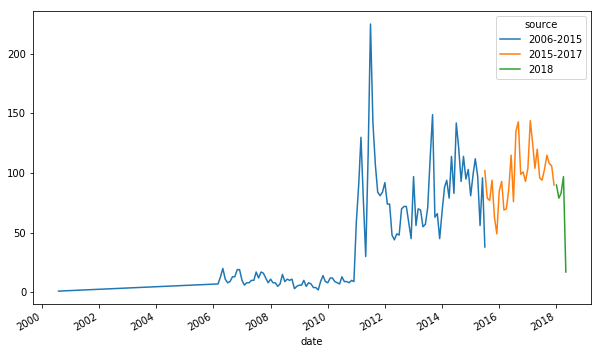

In [8]:
(
    monthly_complaints_by_source
    .plot(figsize = (10, 6))
);

In [9]:
(    
    monthly_complaints_by_source
    .loc[lambda df: df.notnull().sum(axis = 1) > 1]
)

source,2006-2015,2015-2017,2018
date,,,
2015-07-01,38.0,102.0,NaN


This cell summarizes counts of complaints annually using the three columns created in the previous dataframe and selecting the value of each row that contains the highest number to avoid double counting complaints that may appear multiple times across spreadsheets. 

In [10]:
annual_complaint_counts = (
    monthly_complaints_by_source
    .assign(
        count = lambda df: df.max(axis = 1)
    )
    .loc["2012":"2017"]
    .reset_index()
    .assign(
        year = lambda df: df["date"].dt.year
    )
    .groupby("year")
    ["count"]
    .sum()
)

annual_complaint_counts

year
2012     746.0
2013     910.0
2014    1194.0
2015    1005.0
2016    1165.0
2017    1310.0
Name: count, dtype: float64

In [11]:
annual_complaint_counts.mean()

1055.0

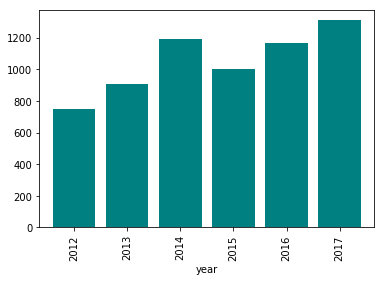

In [12]:
annual_complaint_counts.plot(kind = "bar", color = "teal", width = 0.8);

In [13]:
(
    complaints_combined
    .loc[lambda df: df["date"].notnull()]
    ["Reference Number"]
    .value_counts()
    .loc[lambda x: x > 1]
)

(b)(6)    3305
Name: Reference Number, dtype: int64

### Count the words used in the complaints

This part of the notebook creates a list of words and data affiliated with each word (how many comments used it, how often it was used, and what different iterations of it were used).

This cell checkes whether the `consumer_compls_redacted_2015_2017.xls` file contains any comments that could be useful for a word count analysis.

In [14]:
(
    complaints_combined
    ['Complaint Info Comments']
    .value_counts()
    .head()
)

(b)(6)                                                2951
Refund or Exchange Issues                                8
Possible unauthorized practice of immigration law.       7
Contract Issues                                          7
Complaint Type:  - Customer Service Issues               5
Name: Complaint Info Comments, dtype: int64

The coming cells filter out cells that are either contain no comments or redacted information only. 

In [15]:
nlp = spacy.load('en')

In [16]:
non_redacted_complaints = (
    complaints_combined
    .loc[lambda df: df["Complaint Info Comments"] != "(b)(6)"]
    .loc[lambda df: df["Complaint Info Comments"].notnull()]
)

In [17]:
non_redacted_complaints["Reference Number"].value_counts().head()

(b)(6)         348
b(3); 21(f)      5
47081165         1
45679060         1
50880718         1
Name: Reference Number, dtype: int64

In [18]:
(
    non_redacted_complaints
    .loc[lambda df: df["Reference Number"] == "(b)(6)"]
    .head()
)

,source,Reference Number,Complaint Info Comments,Created Date,date
8173,2018,(b)(6),(b)(6) apartment (b)(6) jersey city nj is curr...,01/03/2018,2018-01-03
8174,2018,(b)(6),"i want to inform case get marriage fake, his n...",01/03/2018,2018-01-03
8175,2018,(b)(6),i want to make sure that they won't use my inf...,01/04/2018,2018-01-04
8176,2018,(b)(6),I'm (b)(6) a graduate student at (b)(6). I'm c...,01/04/2018,2018-01-04
8177,2018,(b)(6),A person called me and informed me that my ali...,01/05/2018,2018-01-05


The cells below create a data frame, `word_rows`, from every complaint comment. Each row contains the tokenized word, the word's lemmatized version, and a complaint index. 

In [19]:
import re
whitespace_pat = re.compile(r"[\s•]+")

In [20]:
%%time
word_rows = []
for i, row in non_redacted_complaints.iterrows():
    clean_comment = re.sub(whitespace_pat, " ", row["Complaint Info Comments"])
    for token in nlp(clean_comment):
        word_rows.append({
            "word": token.text.lower(),
            "lemma": token.lemma_,
            "complaint_index": i
        })

CPU times: user 4min 27s, sys: 41.8 s, total: 5min 9s
Wall time: 3min 15s


In [21]:
words_dataframe = pd.DataFrame(word_rows)
words_dataframe.head()

,complaint_index,lemma,word
0,0,want,wants
1,0,to,to
2,0,report,report
3,0,possible,possible
4,0,fraud,fraud


Based on the `word_rows` data frame, the next cell finds the total word count, the count for the number of comments using the word, and what iterations of the word that were used:

In [22]:
lemma_counts = (
    words_dataframe
    .groupby("lemma")
    .pipe(lambda grp: pd.DataFrame({
        "total_count": grp.size(),
        "unique_comments": grp["complaint_index"].nunique(),
        "words": grp["word"].apply(lambda x: " | ".join(sorted(set(x))))
    }))
)

lemma_counts.head()

,total_count,unique_comments,words
lemma,,,
,58,58,
!,1054,476,!
"""",2096,506,""" | “ | ”"
"""-",18,7,"""-"
"""all",1,1,"""all"


In [23]:
(
    lemma_counts
    .sort_values("unique_comments", ascending = False)
    .head(30)
)

,total_count,unique_comments,words
lemma,,,
.,38643,5213,.
-PRON-,90532,5098,'s | em | he | her | hers | herself | him | hi...
be,31999,4919,'m | 're | 's | am | are | be | been | being |...
to,29018,4840,na | to
the,35591,4566,the
a,16265,4465,a
and,23386,4443,and | ands
for,12014,3888,for
that,12904,3701,that | thats


In [24]:
(    
    lemma_counts
    .to_csv(
        "../output/word_counts.csv",
    )
)

---

---

---